In [0]:
from fastai import *
from fastai.text import *
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re

In [0]:
def clean_ascii(text):
    # function to remove non-ASCII characters from data
    return ''.join(i for i in text if ord(i) < 128)

In [0]:
# path to training files
trainfile = 'data.csv'

In [0]:
# read csv into dataframe
train_data = pd.read_csv(trainfile, delimiter='\t', header=None, encoding = "latin-1")
train_data.columns =["Tid","Tweet", "Label"] # assing column names

train_data.drop('Tid', axis=1, inplace=True) # remove TweetId column

train_data['Label'] = train_data['Label'].str.strip() # remove whitespaces from class labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


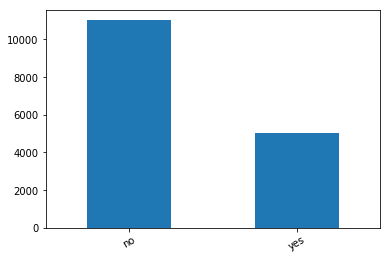

In [7]:
# Convert dataset into 2-class dataset (cyberbullying: yes or no)
bullying = train_data.loc[train_data['Label']!="none"]
no_bullying =train_data.loc[train_data['Label']=="none"]

bullying['Label']="yes"
no_bullying['Label']="no"
train_data = pd.concat([no_bullying, bullying], ignore_index=True)

train_data['Label'].value_counts().plot.bar(rot=30);

In [9]:
# data cleaning and overview
train_data['Tweet'] = train_data['Tweet'].apply(clean_ascii)

train_data.head()

,Tweet,Label
0,RT @colonelkickhead: Another bloody instant re...,no
1,@azzamalirhabi @JihadiA8 This video of the Pes...,no
2,Oh really? No more instant restaurants? THAT'S...,no
3,RT @Benfrancisallen: It hasn't been a good few...,no
4,RT @NoToFeminism: I dont need femisnsn because...,no


In [11]:
#ULMFit requires just the label and the text data (i.e. tweets) for the language-model finetuning & classification 
train_temp = pd.concat([train_data['Label'], train_data['Tweet']], axis=1)
train_temp.tail()

,Label,Tweet
16045,yes,@mykitchenrules @bjtqld: #mkr2015 #mkr I thin...
16046,yes,@RealLifeYamcha: @YesYoureSexist Remind me whe...
16047,yes,LMFAO @BrandonHonaker1 LMFAO who cares about t...
16048,yes,"RT @MyDearWormwood: ""I want equal rights, but ..."
16049,yes,RT @alexxxarich: Go ahead and call me sexist b...


In [0]:
# Split data into train and test data with 80:20 ratio
train, test = train_test_split(train_temp, test_size=0.2)

#print(train['Label'].value_counts())
#print(test['Label'].value_counts())

# Write train & test to csv
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_csv('./', 'train.csv', min_freq=1)

In [0]:
# Save the language and classifier model data for re-use
data_lm.save()

In [15]:
data_lm.show_batch()

idx,text
0,"everyone how pretty we are "" # mkr xxbos xxup rt @_marisajane : xxmaj another round of instant restaurants ? xxmaj are you serious # xxup mkr ? xxmaj yawn ... xxbos xxmaj fuck . # xxup mkr xxbos xxup rt @a_man_in_black : @freebsdgirl xxmaj hey , did you know xxup ks 's xxup tos prohibits doxxing people ? xxbos .@sir5000 just entered xxmaj california . xxmaj the mountains are"
1,"ypn5kfxzyz xxbos xxup rt @cameron_gray : cc : xxmaj silent xxmaj western feminists xxup mt @ilnewsflash : # xxup isis xxmaj executes 7 xxmaj women xxmaj for xxmaj refusing xxmaj temporary xxmaj marriage ( xxmaj rape ) http : / / t.c xxbos xxup rt @ikralla : xxmaj khadgar , you 're so sassy . http : / / t.co / h1zs9v2wl4 xxbos @thequinnspiracy you are fucking amazing , and"
2,racism in xxmaj islam . http : / / t.co / c897nnkbmo xxbos @tmclaughbos @_roguest4r i think i got mine because no one else wanted to touch the code i was working with . :) xxbos xxmaj apparently you are not following the many misogynists i xxup rt @ben_humes xxmaj why is everything for girls or related to girls on xxmaj twitter ? # notsexist xxbos @sirajzarook @bilalighumman @odiniainvictus @israeliregime
3,i hate xxmaj islam because it is a religion based on hatred and xxmaj jihad . http : / / t.co / n60i1tfxhw xxbos xxup rt @cammyhoskins98 xxmaj sorry but girls will never be able to compete at the level of football that men 's football has set # notsexist xxbos @jasonverlanderr my mistake ! xxmaj sounded like it could have been sympathetic lol . :) xxbos xxmaj poor xxmaj
4,"stupid . xxmaj most women are not feminists . xxmaj but 100 answers ... i 'll focus on 2 xxbos xxup haha @tharodickk i m not sexist xxrep 4 . but i honestly think only men should be reporting on xxmaj football on xxmaj sportscenter ... just saying haha xxbos @asciibear @thequinnspiracy xxup make xxup me xxbos @_dirtytruths xxmaj sanctions did n't kill anyone , birdbrain . xxmaj there were"


In [0]:
# learner object uses the tokenized language model data
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


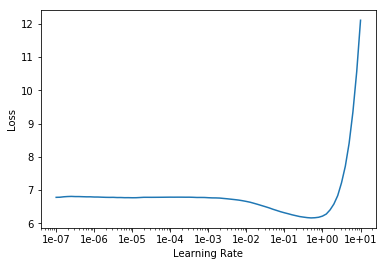

In [17]:
# Find the optimum learning rate
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [18]:
# Download FastAI languae model and fine-tune it
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.443177,5.784115,0.177264,00:13


In [19]:
# Unfreeze all layers of the model for fine-tuning languae model
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7)) # 20 epochs for fine-tuning the LM

epoch,train_loss,valid_loss,accuracy,time
0,5.485820,4.864896,0.241837,00:17
1,5.131323,4.682568,0.266948,00:16
2,4.816265,4.477241,0.293272,00:16
3,4.524069,4.324331,0.301626,00:16
4,4.255662,4.179644,0.315545,00:16
5,3.983536,4.144608,0.319834,00:16
6,3.718543,4.136895,0.319962,00:16
7,3.440294,4.174531,0.323103,00:16
8,3.178261,4.189563,0.322513,00:16
9,2.928606,4.258526,0.322242,00:16


In [0]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv('./', 'train.csv', vocab=data_lm.train_ds.vocab,min_freq=1, bs=32)
data_clas.save()

In [0]:
# Download classification model and fine-tune it
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


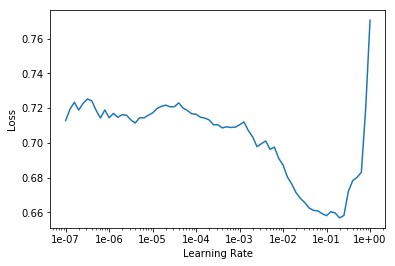

In [23]:
# Find the optimum learning rate for classification model
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [24]:
# Fine-tune all three layers of the model
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.466542,0.414479,0.811211,00:08


In [25]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.431786,0.377982,0.819385,00:09


In [26]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.404208,0.366622,0.834955,00:15


In [27]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.348008,0.363745,0.842351,00:19
1,0.333417,0.360745,0.850915,00:20
2,0.306683,0.365880,0.850525,00:19
3,0.298142,0.366194,0.859089,00:20
4,0.268285,0.376121,0.858700,00:19
5,0.232939,0.404161,0.855975,00:19
6,0.211597,0.418444,0.862982,00:19
7,0.183556,0.429858,0.864928,00:19
8,0.187198,0.436428,0.862592,00:21
9,0.180503,0.431754,0.865707,00:19


In [28]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,1587,205
1,140,637


In [29]:
# Evaluate model performance on test data
test = pd.read_csv('test.csv', encoding = "latin-1")
test.head()

,Label,Tweet
0,no,@SirajZarook The Jews of Khybar lived in Khyba...
1,yes,RT @Jack_McCormick1: I like my pickles like my...
2,yes,I mean. You've stooped this low after serving ...
3,no,RT @dsyndergaard: More voters side with Netany...
4,no,@harmlesstree2 Here. https://t.co/xWJzpSodGj


In [30]:
# Apply the predict method to produce our prediction
test['Predicted'] = test['Tweet'].apply(lambda row: str(learn.predict(row)[0]))
test.head()

,Label,Tweet,Predicted
0,no,@SirajZarook The Jews of Khybar lived in Khyba...,no
1,yes,RT @Jack_McCormick1: I like my pickles like my...,yes
2,yes,I mean. You've stooped this low after serving ...,no
3,no,RT @dsyndergaard: More voters side with Netany...,no
4,no,@harmlesstree2 Here. https://t.co/xWJzpSodGj,no


In [0]:
# Write the results to csv
test.to_csv("prediction.csv")